In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Projects/Anagha/Images.zip"

In [ ]:
path = "/content/drive/MyDrive/Projects/Anagha/Images"


In [ ]:
!unzip -q $zip_path -d $path

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Projects/Anagha/Images"

# About Dataset

<img src="https://th.bing.com/th/id/R.a672705de96542b9f120f7dabc9dbf9a?rik=iEzFJf%2blYr0Acw&riu=http%3a%2f%2fpediatricophthalmologypa.com%2fwp-content%2fuploads%2f2014%2f01%2fDiabetic-Retinopathy-Blindness.png&ehk=vb2qvyFjNGpv6VGQWbnvpiIgpGtoCRrrPZKkJ4DMNMc%3d&risl=&pid=ImgRaw&r=0" alt="centered image" image align ="right" class="sc-hTnXLe UAvdY"
     width = '600'
     height ='900'/>

## Total Class Labels = 5

## Total Images = 2750

### 1. Healthy (Not DR) = 1000

### 2. Mild DR = 370

### 3. Moderate DR = 900

### 4. Proliferative DR = 290

### 5. Severe DR = 190

### DR: Diabetic Retinopathy



>

# 1 Import libraries

In [ ]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


# 2 Read Data and Preprocessing


### Diabetic retinopathy is a complication of diabetes and a leading cause of blindness. It occurs when diabetes damages the tiny blood vessels inside the retina, the light-sensitive tissue at the back of the eye. A healthy retina is necessary for good vision.
If you have diabetic retinopathy, at first you may notice no changes to your vision. But over time, diabetic retinopathy can get worse and cause vision loss. Diabetic retinopathy usually affects both eyes.

### Diabetic Retinopathy has four stages:

## Mild Nonproliferative Retinopathy
At this earliest stage, microaneurysms occur. They are small areas of balloon-like swelling in the retina’s tiny blood vessels.

## Moderate Nonproliferative Retinopathy
As the disease progresses, some blood vessels that nourish the retina are blocked.

## Severe Nonproliferative Retinopathy
Many more blood vessels are blocked, depriving several areas of the retina with their blood supply. These areas of the retina send signals to the body to grow new blood vessels for nourishment.

## Proliferative Retinopathy
At this advanced stage, the signals sent by the retina for nourishment trigger the growth of new blood vessels. These new blood vessels are abnormal and fragile. They grow along the retina and along the surface of the clear, vitreous gel that fills the inside of the eye.




### Oversampling techniques for classification problems

#### 1 Random oversampling
Random Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once (2x, 3x, 5x, 10x, etc.) This is one of the earliest proposed methods, that is also proven to be robust.[3] Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement.

#### 2 Augmentation
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.[8] (See: Data augmentation)


## A- Random Over sampling

more preferred with text data not with images

### B Train Valid Split
### C- Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
BASE_PATH = '/content/drive/MyDrive/Projects/Anagha/Images/Images'

# Image properties
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create generators
tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    validation_split=0.2  # Split into train/valid
)

t_G = ImageDataGenerator()

# Generate data
Train = tr_G.flow_from_directory(
    BASE_PATH,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'  # Important
)

Valid = tr_G.flow_from_directory(
    BASE_PATH,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='validation'  # Important
)

Test = t_G.flow_from_directory(
    BASE_PATH,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 1021 images belonging to 5 classes.
Found 254 images belonging to 5 classes.
Found 1275 images belonging to 5 classes.


## D- Represent a sample

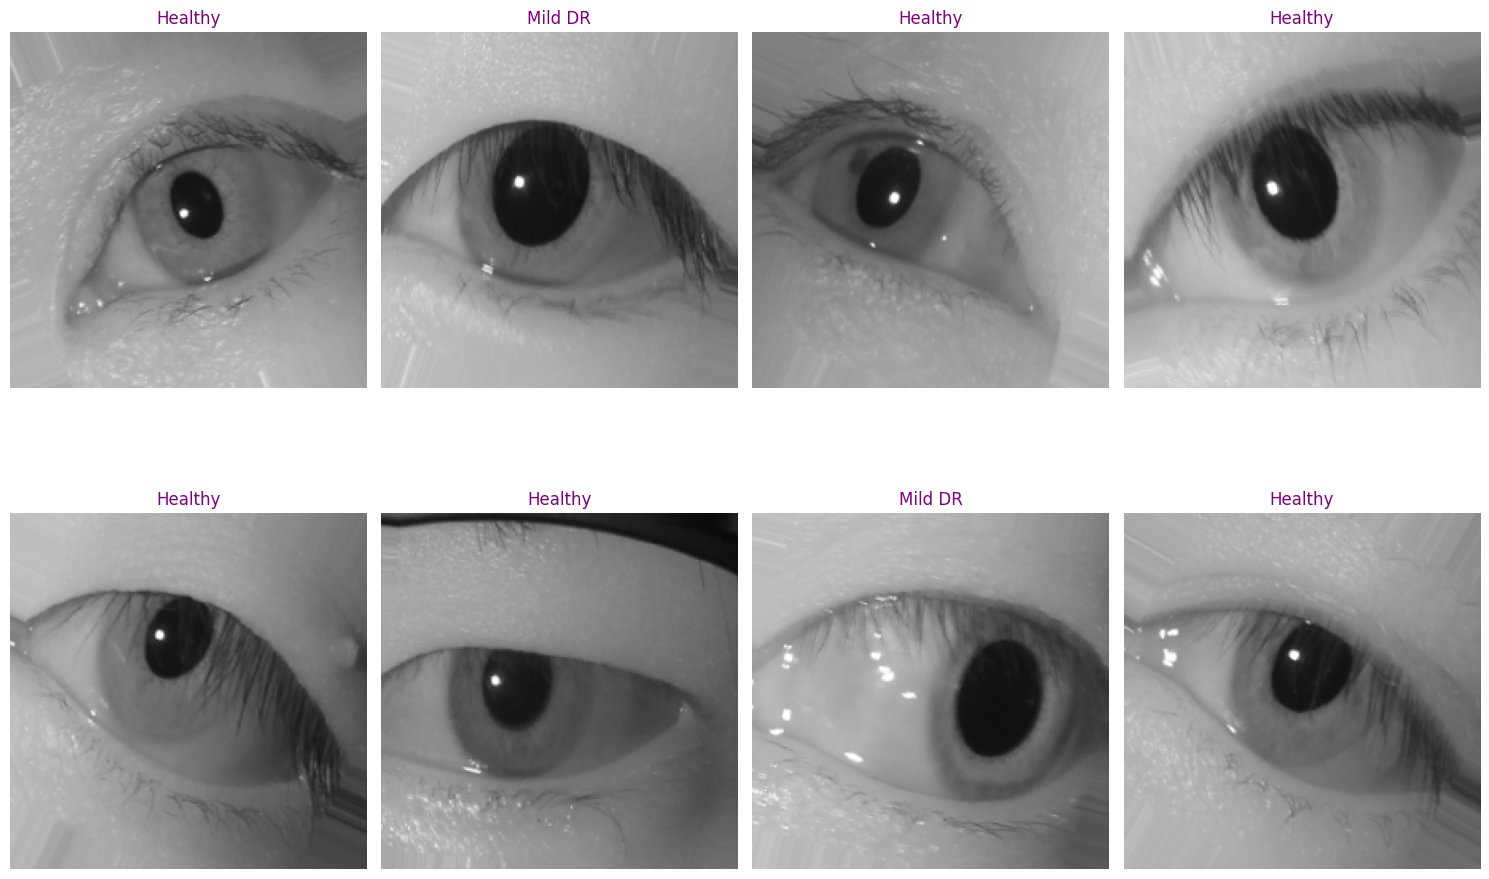

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

## A- Create a model using transfer learning with EfficientNetB2


In [ ]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
img_shape = (img_size[0], img_size[1], 3)
EPOCHS = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Residual Network (ResNet)

In [ ]:
base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model_resnet = Sequential([
    base_model_resnet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_resnet.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801,669 (94.61 MB)

 Trainable params: 24,748,549 (94.41 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Visualize model layers

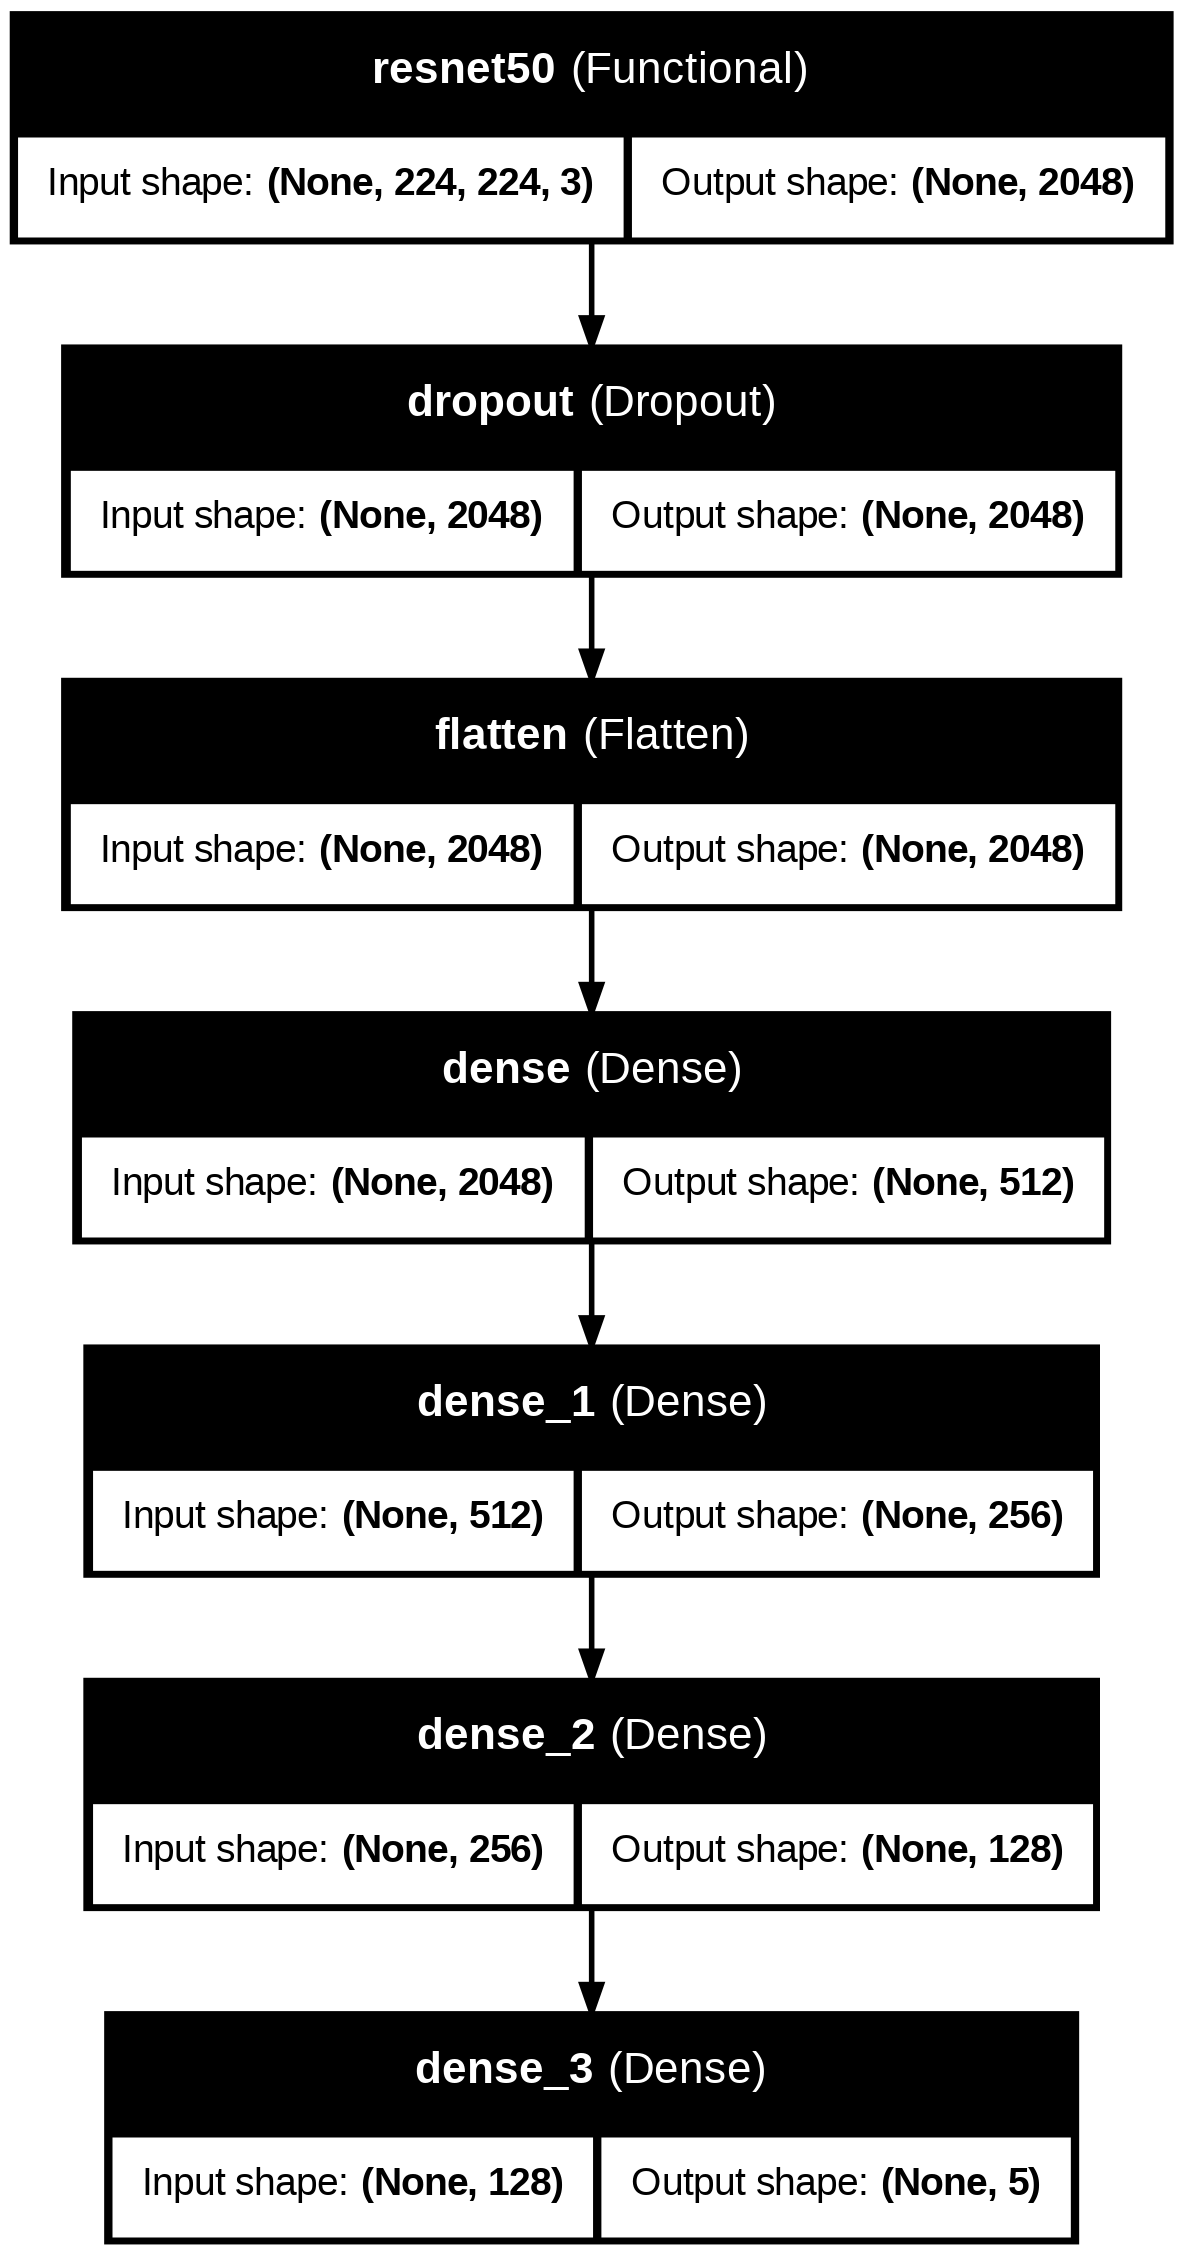

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot and display architecture for ResNet50 model
plot_model(model_resnet, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)
Image(filename='resnet_model.png')

## Training ResNet

In [ ]:
np.random.seed(42)
history_resnet = model_resnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[early_stopping]
)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5554 - loss: 3.6546 - val_accuracy: 0.7756 - val_loss: 1.6761
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 849ms/step - accuracy: 0.7136 - loss: 1.2909 - val_accuracy: 0.7756 - val_loss: 1.3619
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 877ms/step - accuracy: 0.7075 - loss: 1.1342 - val_accuracy: 0.7756 - val_loss: 1.7249
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 845ms/step - accuracy: 0.7465 - loss: 0.9658 - val_accuracy: 0.7795 - val_loss: 1.7567
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 849ms/step - accuracy: 0.8172 - loss: 0.6973 - val_accuracy: 0.7795 - val_loss: 1.5492
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 850ms/step - accuracy: 0.7873 - loss: 0.7601 - val_accuracy: 0.7756 - val_loss: 1.9252
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 860ms/step - accuracy: 0.7984 - loss: 0.7315 - val_accuracy: 0.7835 - val_loss: 1.8234


In [ ]:
tr_acc_resnet = history_resnet.history['accuracy']
tr_loss_resnet = history_resnet.history['loss']
v_acc_resnet = history_resnet.history['val_accuracy']
v_loss_resnet = history_resnet.history['val_loss']
index_acc_resnet = np.argmax(v_acc_resnet)
high_Vacc_resnet = v_acc_resnet[index_acc_resnet]
index_loss_resnet = np.argmin(v_loss_resnet)
low_Vloss_resnet = v_loss_resnet[index_loss_resnet]
Epochs_resnet = list(range(1, len(tr_acc_resnet) + 1))
best_acc_resnet = f'Best epoch ={str(index_acc_resnet + 1)}'
best_loss_resnet = f'Best epoch ={str(index_loss_resnet + 1)}'

# Densenet169

In [ ]:
np.random.seed(42)
base_model_densenet = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model_densenet = Sequential([
    base_model_densenet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
np.random.seed(42)
model_densenet.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model_densenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       852,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,660,229 (52.11 MB)

 Trainable params: 13,501,829 (51.51 MB)

 Non-trainable params: 158,400 (618.75 KB)

## Visualize model layers

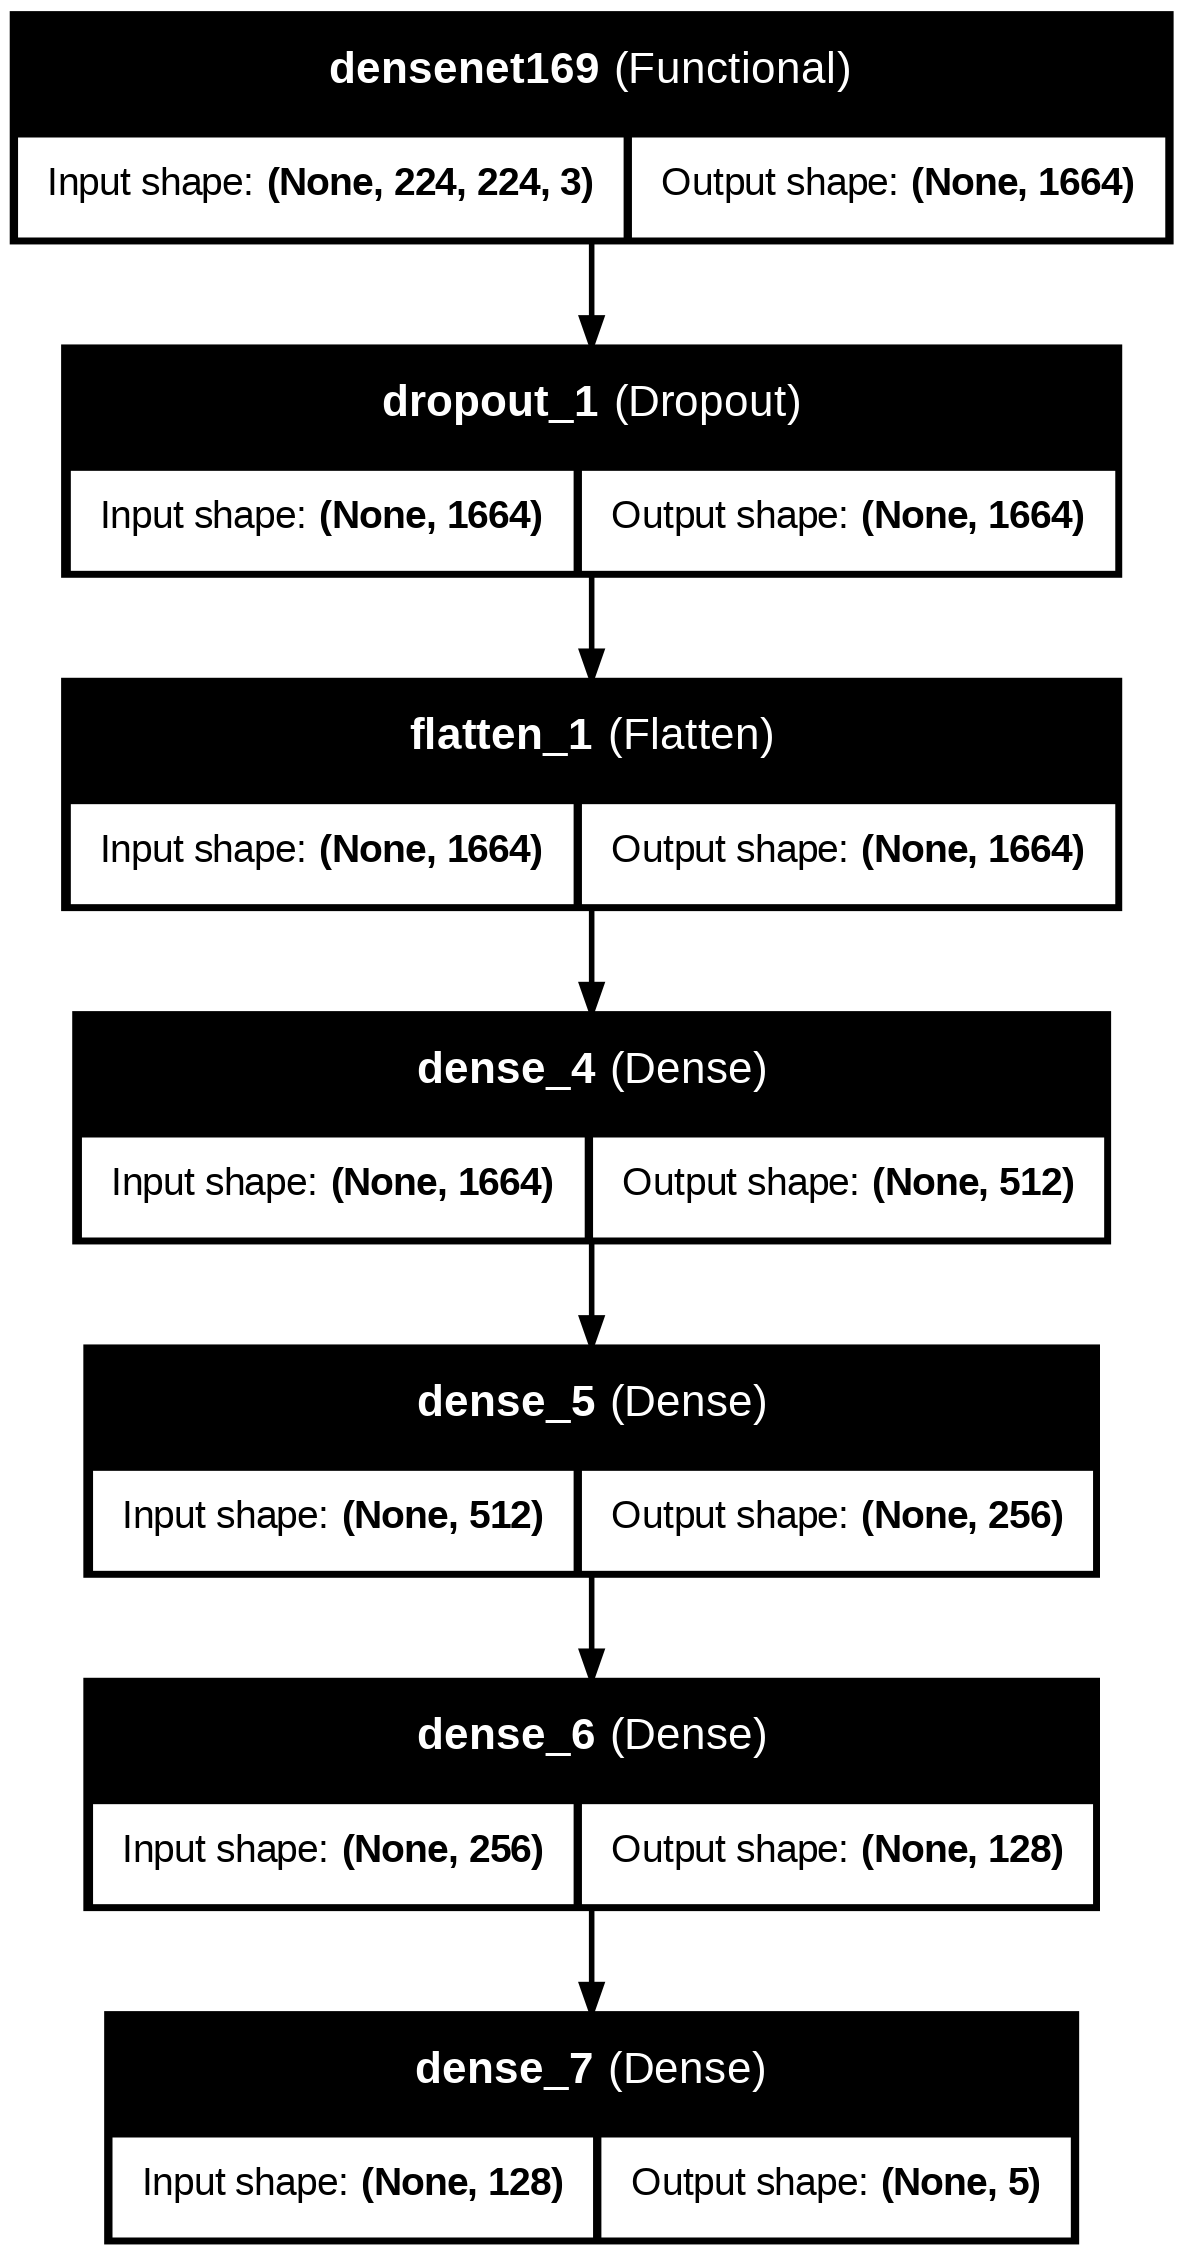

In [ ]:
# Plot and display architecture for DenseNet169 model
plot_model(model_densenet, to_file='densenet_model.png', show_shapes=True, show_layer_names=True)
Image(filename='densenet_model.png')

## Training DenseNet

In [ ]:
np.random.seed(42)

history_densenet = model_densenet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - acc: 0.6407 - loss: 1.8327 - val_acc: 0.6614 - val_loss: 1.0138
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 896ms/step - acc: 0.7212 - loss: 0.9614 - val_acc: 0.7795 - val_loss: 1.0475
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 894ms/step - acc: 0.7633 - loss: 0.7523 - val_acc: 0.7913 - val_loss: 0.9321
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 886ms/step - acc: 0.7960 - loss: 0.6892 - val_acc: 0.7835 - val_loss: 0.9148
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 881ms/step - acc: 0.8110 - loss: 0.6266 - val_acc: 0.7874 - val_loss: 0.9966
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 871ms/step - acc: 0.7983 - loss: 0.6042 - val_acc: 0.7756 - val_loss: 0.9425
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 877ms/step - acc: 0.8220 - loss: 0.5109 - val_acc: 0.7717 - val_loss: 1.0488
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 892ms/step - acc: 0.8306 - loss: 0.4710 - val_acc: 0.7717 - val_loss: 1.0965
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 909ms/st

In [ ]:
# DenseNet169 history variables
tr_acc_densenet = history_densenet.history['acc']
tr_loss_densenet = history_densenet.history['loss']
v_acc_densenet = history_densenet.history['val_acc']
v_loss_densenet = history_densenet.history['val_loss']
index_acc_densenet = np.argmax(v_acc_densenet)
high_Vacc_densenet = v_acc_densenet[index_acc_densenet]
index_loss_densenet = np.argmin(v_loss_densenet)
low_Vloss_densenet = v_loss_densenet[index_loss_densenet]
Epochs_densenet = list(range(1, len(tr_acc_densenet) + 1))
best_acc_densenet = f'Best epoch ={str(index_acc_densenet + 1)}'
best_loss_densenet = f'Best epoch ={str(index_loss_densenet + 1)}'


# EfficientNetB3

In [ ]:
# EfficientNetB3 model
np.random.seed(42)
checkpoint_path = '/content/drive/MyDrive/efficientnet_checkpoint.h5'

base_model_efficientnet = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model_efficientnet = Sequential([
    base_model_efficientnet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
np.random.seed(42)
model_efficientnet.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)


In [ ]:
np.random.seed(42)
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
model_efficientnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

## Visualize model layers

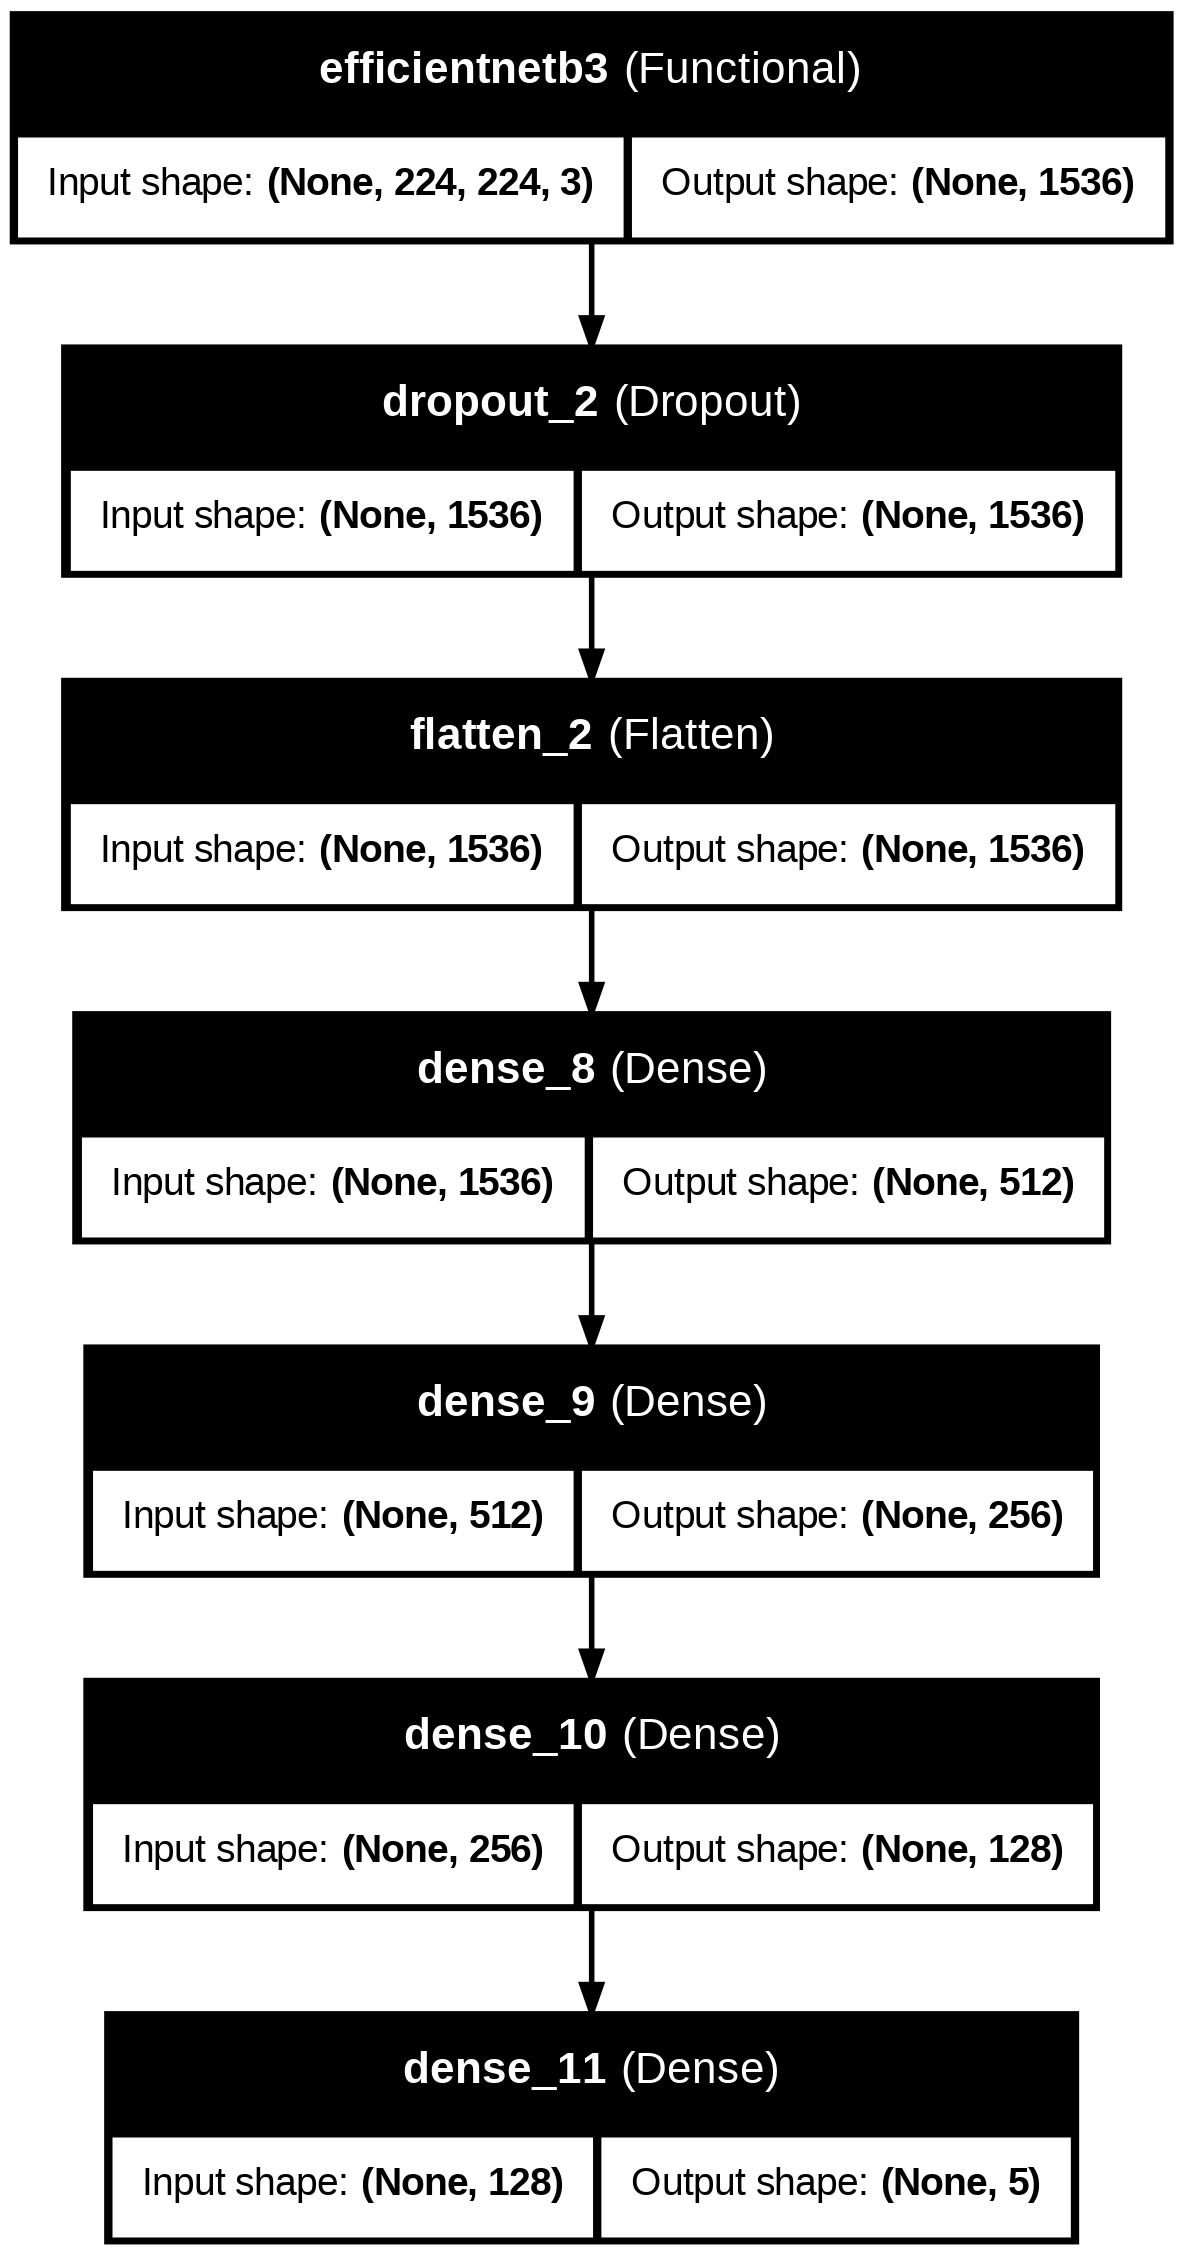

In [ ]:
# Plot and display architecture for EfficientNetB3 model
from PIL import Image

# Plot and display architecture for EfficientNetB3 model
plot_model(model_efficientnet, to_file='efficientnet_model.png', show_shapes=True, show_layer_names=True)
Image.open('efficientnet_model.png')



## Training EfficientNetB3

In [ ]:
np.random.seed(42)
history_efficientnet = model_efficientnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    validation_steps=None,
    callbacks=[checkpoint],
    shuffle=False
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - acc: 0.6287 - loss: 1.9202 - val_acc: 0.7520 - val_loss: 1.0336
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 849ms/step - acc: 0.6987 - loss: 1.1361 - val_acc: 0.7362 - val_loss: 0.9331
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 833ms/step - acc: 0.7117 - loss: 0.9842 - val_acc: 0.7283 - val_loss: 0.9463
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step - acc: 0.7044 - loss: 0.9404 - val_acc: 0.7677 - val_loss: 0.8883
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 837ms/step - acc: 0.7722 - loss: 0.7640 - val_acc: 0.7559 - val_loss: 0.8921
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 845ms/step - acc: 0.7530 - loss: 0.8867 - val_acc: 0.7559 - val_loss: 0.8961
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 858ms/step - acc: 0.7682 - loss: 0.7208 - val_acc: 0.7480 - val_loss: 0.8072
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 877ms/step - acc: 0.8153 - loss: 0.6834 - val_acc: 0.7402 - val_loss: 0.8709
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 867ms/st

In [ ]:
# EfficientNetB3 history variables
tr_acc_efficientnet = history_efficientnet.history['acc']
tr_loss_efficientnet = history_efficientnet.history['loss']
v_acc_efficientnet = history_efficientnet.history['val_acc']
v_loss_efficientnet = history_efficientnet.history['val_loss']
index_acc_efficientnet = np.argmax(v_acc_efficientnet)
high_Vacc_efficientnet = v_acc_efficientnet[index_acc_efficientnet]
index_loss_efficientnet = np.argmin(v_loss_efficientnet)
low_Vloss_efficientnet = v_loss_efficientnet[index_loss_efficientnet]
Epochs_efficientnet = list(range(1, len(tr_acc_efficientnet) + 1))
best_acc_efficientnet = f'Best epoch ={str(index_acc_efficientnet + 1)}'
best_loss_efficientnet = f'Best epoch ={str(index_loss_efficientnet + 1)}'


# Evaluation

## ResNet50

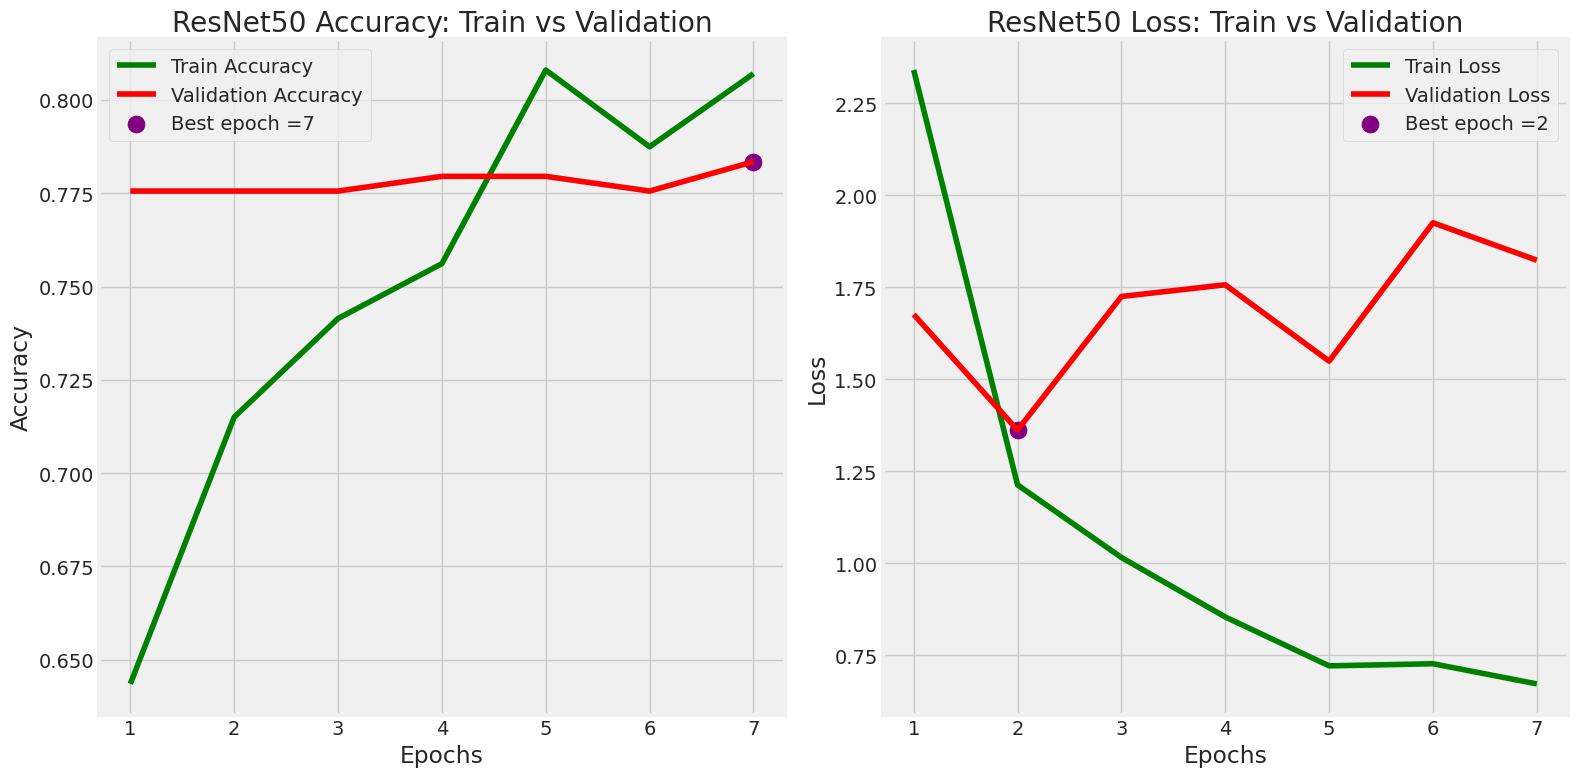

In [ ]:

# Plotting for ResNet50 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_resnet, tr_acc_resnet, "g", label="Train Accuracy")
plt.plot(Epochs_resnet, v_acc_resnet, "r", label="Validation Accuracy")
plt.scatter(index_acc_resnet + 1, high_Vacc_resnet, s=150, color='purple', label=best_acc_resnet)
plt.title("ResNet50 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_resnet, tr_loss_resnet, "g", label="Train Loss")
plt.plot(Epochs_resnet, v_loss_resnet, "r", label="Validation Loss")
plt.scatter(index_loss_resnet + 1, low_Vloss_resnet, s=150, color='purple', label=best_loss_resnet)
plt.title("ResNet50 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## DenseNet169

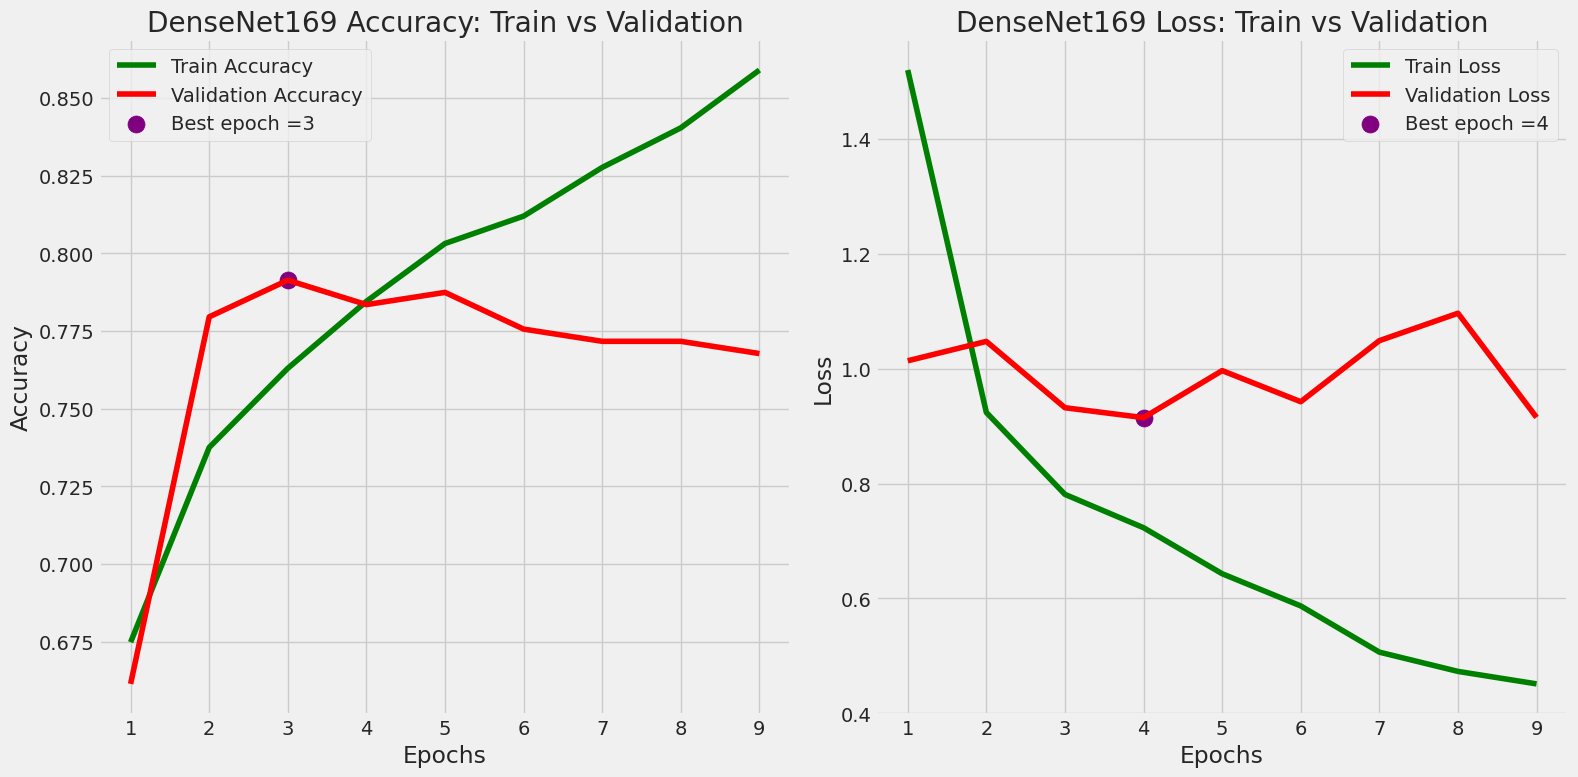

In [ ]:
# Plotting for DenseNet169 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_densenet, tr_acc_densenet, "g", label="Train Accuracy")
plt.plot(Epochs_densenet, v_acc_densenet, "r", label="Validation Accuracy")
plt.scatter(index_acc_densenet + 1, high_Vacc_densenet, s=150, color='purple', label=best_acc_densenet)
plt.title("DenseNet169 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_densenet, tr_loss_densenet, "g", label="Train Loss")
plt.plot(Epochs_densenet, v_loss_densenet, "r", label="Validation Loss")
plt.scatter(index_loss_densenet + 1, low_Vloss_densenet, s=150, color='purple', label=best_loss_densenet)
plt.title("DenseNet169 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## EfficientNetB3

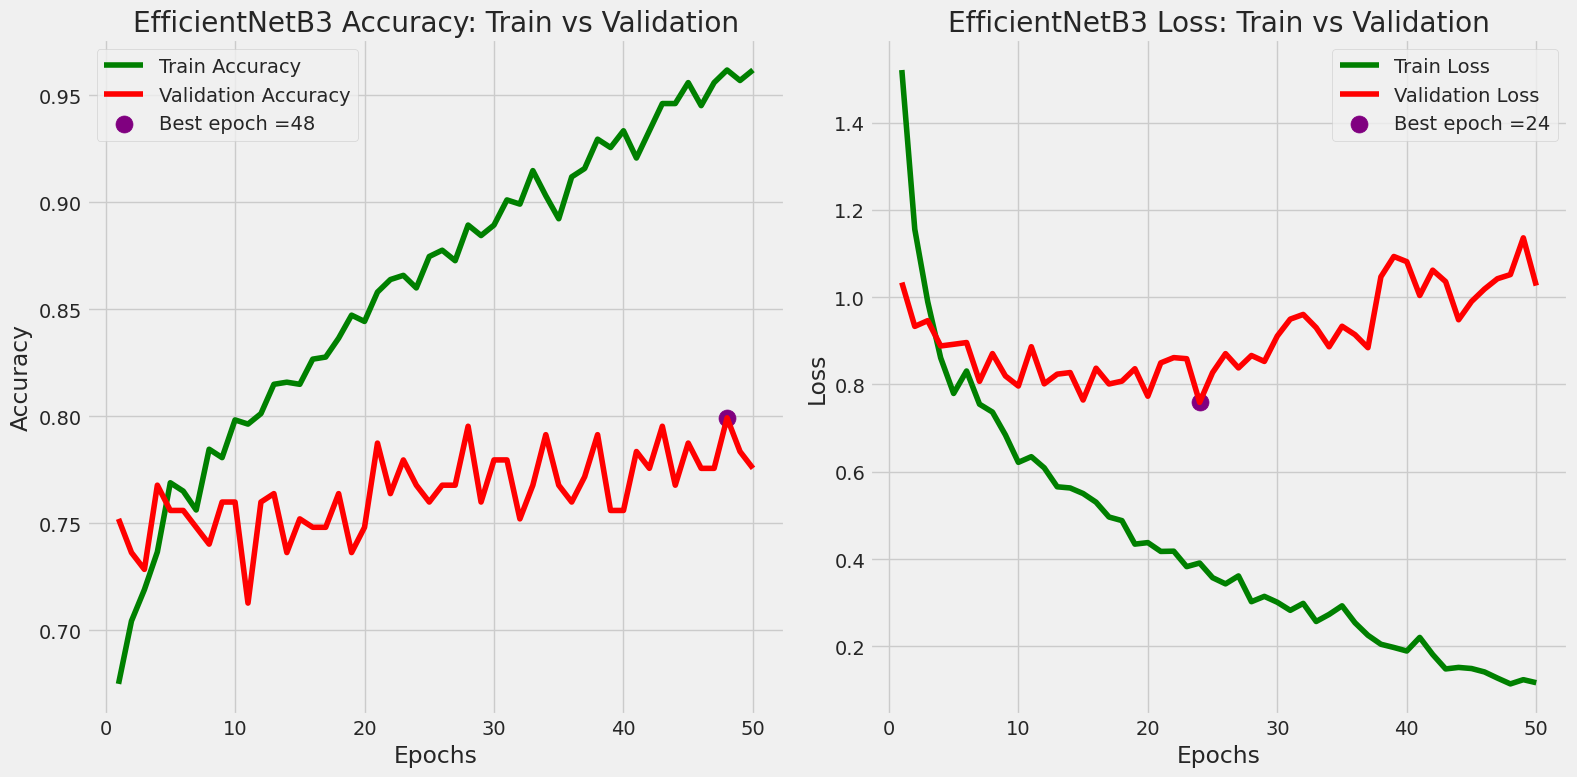

In [ ]:
# Plotting for EfficientNetB3 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_efficientnet, tr_acc_efficientnet, "g", label="Train Accuracy")
plt.plot(Epochs_efficientnet, v_acc_efficientnet, "r", label="Validation Accuracy")
plt.scatter(index_acc_efficientnet + 1, high_Vacc_efficientnet, s=150, color='purple', label=best_acc_efficientnet)
plt.title("EfficientNetB3 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_efficientnet, tr_loss_efficientnet, "g", label="Train Loss")
plt.plot(Epochs_efficientnet, v_loss_efficientnet, "r", label="Validation Loss")
plt.scatter(index_loss_efficientnet + 1, low_Vloss_efficientnet, s=150, color='purple', label=best_loss_efficientnet)
plt.title("EfficientNetB3 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Defining Variables

## ResNet50

In [ ]:
# Evaluate ResNet50 model
train_scores_resnet = model_resnet.evaluate(Train, verbose=1)
test_scores_resnet = model_resnet.evaluate(Test, verbose=1)

# Print scores for ResNet50 model
print('ResNet50 Model Scores:')
print('Train Accuracy:', train_scores_resnet[1])
print('Train Loss:', train_scores_resnet[0])
print('Test Accuracy:', test_scores_resnet[1])
print('Test Loss:', test_scores_resnet[0])


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 674ms/step - accuracy: 0.7488 - loss: 1.4573
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 433ms/step - accuracy: 0.9637 - loss: 0.2464
ResNet50 Model Scores:
Train Accuracy: 0.7708129286766052
Train Loss: 1.3538817167282104
Test Accuracy: 0.7733333110809326
Test Loss: 1.4474314451217651


## DenseNet169

In [ ]:
# Evaluate DenseNet169 model
train_scores_densenet = model_densenet.evaluate(Train, verbose=1)
test_scores_densenet = model_densenet.evaluate(Test, verbose=1)

# Print scores for DenseNet169 model
print('DenseNet169 Model Scores:')
print('Train Accuracy:', train_scores_densenet[1])
print('Train Loss:', train_scores_densenet[0])
print('Test Accuracy:', test_scores_densenet[1])
print('Test Loss:', test_scores_densenet[0])


32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 960ms/step - acc: 0.8000 - loss: 0.6898
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 716ms/step - acc: 0.9608 - loss: 0.1882
DenseNet169 Model Scores:
Train Accuracy: 0.7992164492607117
Train Loss: 0.6737360954284668
Test Accuracy: 0.7976470589637756
Test Loss: 0.8390666842460632


## EfficientNetB3

In [ ]:
# Evaluate EfficientNetB3 model
train_scores_efficientnet = model_efficientnet.evaluate(Train, verbose=1)
test_scores_efficientnet = model_efficientnet.evaluate(Test, verbose=1)

# Print scores for EfficientNetB3 model
print('EfficientNetB3 Model Scores:')
print('Train Accuracy:', train_scores_efficientnet[1])
print('Train Loss:', train_scores_efficientnet[0])
print('Test Accuracy:', test_scores_efficientnet[1])
print('Test Loss:', test_scores_efficientnet[0])


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 759ms/step - acc: 0.9974 - loss: 0.0245
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - acc: 0.9318 - loss: 0.2155
EfficientNetB3 Model Scores:
Train Accuracy: 0.9921645522117615
Train Loss: 0.03505062311887741
Test Accuracy: 0.9129411578178406
Test Loss: 0.3335546553134918


# Selecting the best model

In [ ]:
# Evaluate ResNet50 model on test set
test_acc_resnet = model_resnet.evaluate(Test)[1]

# Evaluate DenseNet169 model on test set

test_acc_densenet = model_densenet.evaluate(Test)[1]

# Evaluate EfficientNetB3 model on test set

test_acc_efficientnet = model_efficientnet.evaluate(Test)[1]

# Compare validation accuracies
best_val_accuracy = max(test_acc_resnet, test_acc_densenet, test_acc_efficientnet)

# Compare test accuracies
if best_val_accuracy == test_acc_resnet:
    best_model_name = "ResNet50"
    best_test_accuracy = test_acc_resnet
elif best_val_accuracy == test_acc_densenet:
    best_model_name = "DenseNet169"
    best_test_accuracy = test_acc_densenet
else:
    best_model_name = "EfficientNetB3"
    best_test_accuracy = test_acc_efficientnet

# Print results
print("Accuracies:")
print("ResNet50:", test_acc_resnet)
print("DenseNet169:", test_acc_densenet)
print("EfficientNetB3:", test_acc_efficientnet)
print("\nBest Model Based on Validation Accuracy:", best_model_name)
print("Test Accuracy of Best Model:", best_test_accuracy)


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.9637 - loss: 0.2464
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - acc: 0.9608 - loss: 0.1882
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - acc: 0.9318 - loss: 0.2155
Accuracies:
ResNet50: 0.7733333110809326
DenseNet169: 0.7976470589637756
EfficientNetB3: 0.9129411578178406

Best Model Based on Validation Accuracy: EfficientNetB3
Test Accuracy of Best Model: 0.9129411578178406


# 5 Get  predictions

In [ ]:
import numpy as np

models = {
    model_resnet: "ResNet50",
    model_densenet: "DenseNet169",
    model_efficientnet: "EfficientNetB3"
}

for model, model_name in models.items():  # iterate over keys and values
    print(f"Predictions for Model {model_name}:")

    # Perform predictions
    predictions = model.predict(Test)

    # Get the predicted labels
    y_pred = np.argmax(predictions, axis=1)

    # Print predictions and corresponding labels
    print("Predictions:")
    print(predictions)
    print("Predicted Labels:")
    print(y_pred)
    print()


Predictions for Model ResNet50:
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step
Predictions:
[[9.5678425e-01 4.0070780e-02 2.4295067e-03 3.4110245e-04 3.7417005e-04]
 [9.1517377e-01 7.9649530e-02 1.9425087e-03 2.7522310e-03 4.8214747e-04]
 [9.4460434e-01 1.3887208e-02 3.3337913e-02 4.2756624e-04 7.7429959e-03]
 ...
 [9.6382260e-01 1.4755087e-02 1.7275766e-02 9.7477465e-04 3.1716728e-03]
 [9.8687243e-01 1.7428596e-03 4.5345566e-04 2.1260753e-03 8.8052433e-03]
 [9.4929707e-01 5.2776360e-03 2.3617707e-02 1.3415082e-02 8.3925137e-03]]
Predicted Labels:
[0 0 0 ... 0 0 0]

Predictions for Model DenseNet169:
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 727ms/step
Predictions:
[[9.9315393e-01 1.5348411e-03 6.6070032e-05 1.0108551e-03 4.2342995e-03]
 [9.9913269e-01 1.7372714e-04 5.4574618e-04 8.3941442e-05 6.3827807e-05]
 [9.9969161e-01 3.2129592e-05 3.1978092e-05 1.4961453e-05 2.2928645e-04]
 ...
 [9.6424186e-01 5.6466362e-03 1.2926647e-03 5.3429697e-03 2.3475895e-02]
 [9.6398199e-01 6.6293394e-03 8.8776965e-03 1

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "red")
    plt.tight_layout()
    plt.xlabel('Predictions')
    plt.ylabel('Real Values')
    plt.show()




In [ ]:
classes = list(Test.class_indices.keys())

## Confusion Matrix for ResNet50

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 310ms/step


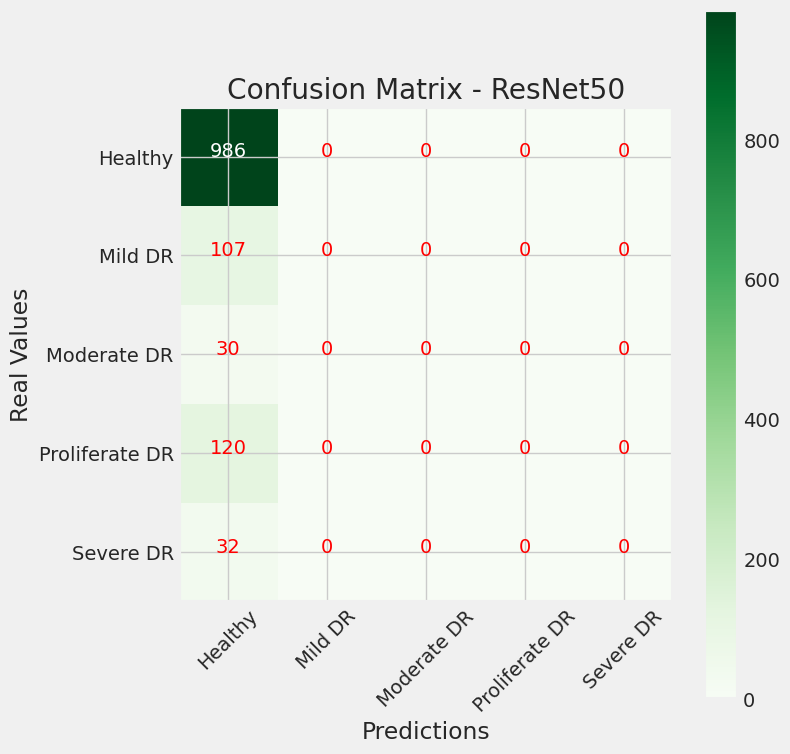

In [ ]:
# Get predictions for ResNet50 model
y_pred_resnet = model_resnet.predict(Test)

# Calculate confusion matrix for ResNet50
cm_resnet = confusion_matrix(Test.classes, np.argmax(y_pred_resnet, axis=1))

# Plot confusion matrix for ResNet50
plot_confusion_matrix(cm_resnet, classes, title='Confusion Matrix - ResNet50')


## Confusion Matrix for DenseNet169

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 403ms/step


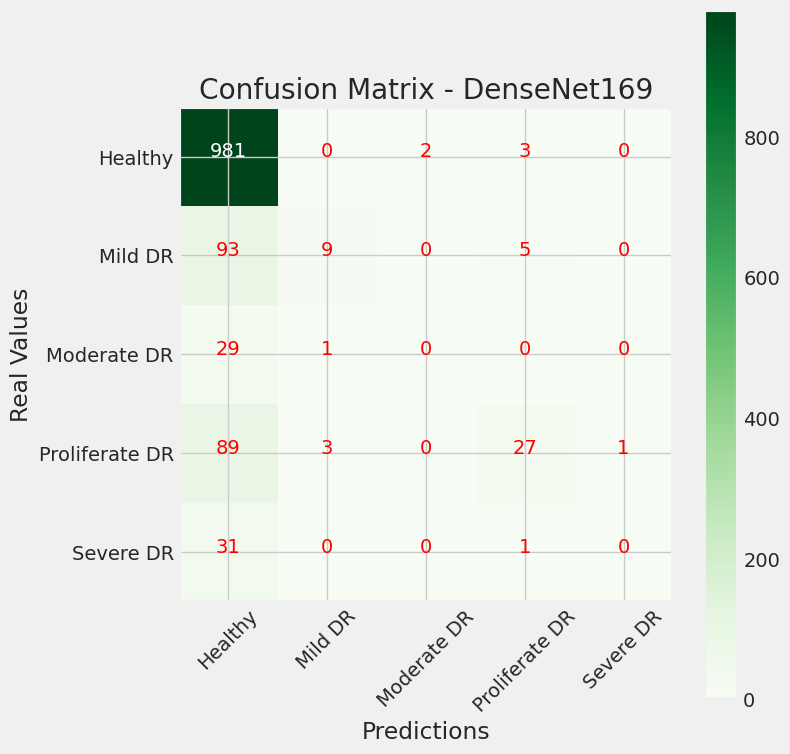

In [ ]:
# Get predictions for DenseNet169 model
y_pred_densenet = model_densenet.predict(Test)

# Calculate confusion matrix for DenseNet169
cm_densenet = confusion_matrix(Test.classes, np.argmax(y_pred_densenet, axis=1))

# Plot confusion matrix for DenseNet169
plot_confusion_matrix(cm_densenet, classes, title='Confusion Matrix - DenseNet169')


## Confusion Matrix for EfficientNetB3

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step


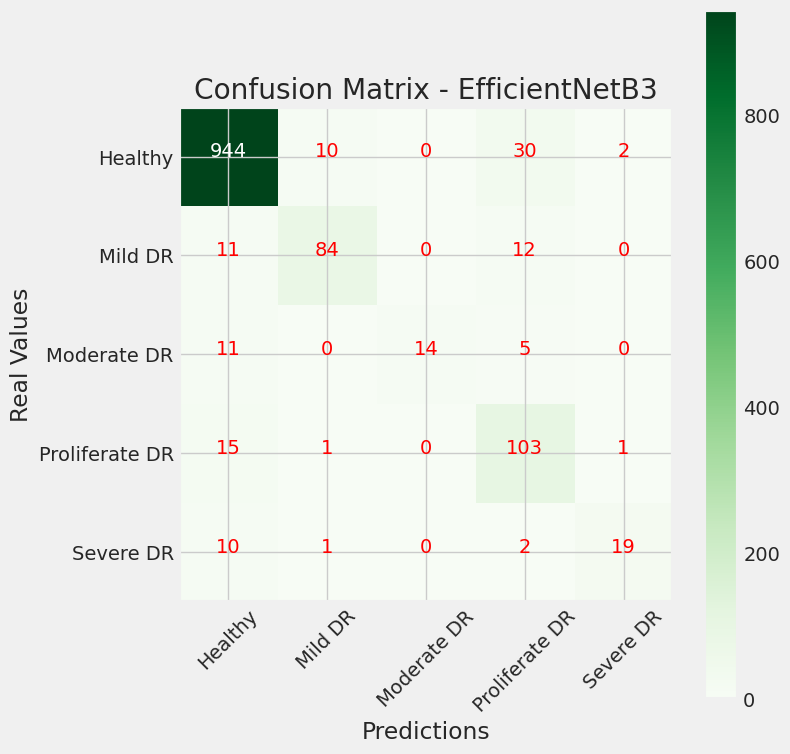

In [ ]:
# Get predictions for EfficientNetB3 model
y_pred_efficientnet = model_efficientnet.predict(Test)

# Calculate confusion matrix for EfficientNetB3
cm_efficientnet = confusion_matrix(Test.classes, np.argmax(y_pred_efficientnet, axis=1))

# Plot confusion matrix for EfficientNetB3
plot_confusion_matrix(cm_efficientnet, classes, title='Confusion Matrix - EfficientNetB3')


In [ ]:
from sklearn.metrics import classification_report

# Generate classification reports for each model
report_resnet = classification_report(Test.classes, np.argmax(y_pred_resnet, axis=1), target_names=classes)
report_densenet = classification_report(Test.classes, np.argmax(y_pred_densenet, axis=1), target_names=classes)
report_efficientnet = classification_report(Test.classes, np.argmax(y_pred_efficientnet, axis=1), target_names=classes)

# Print classification reports
print("Classification Report - ResNet50:\n", report_resnet)
print("\nClassification Report - DenseNet169:\n", report_densenet)
print("\nClassification Report - EfficientNetB3:\n", report_efficientnet)



Classification Report - ResNet50:
                 precision    recall  f1-score   support

       Healthy       0.77      1.00      0.87       986
       Mild DR       0.00      0.00      0.00       107
   Moderate DR       0.00      0.00      0.00        30
Proliferate DR       0.00      0.00      0.00       120
     Severe DR       0.00      0.00      0.00        32

      accuracy                           0.77      1275
     macro avg       0.15      0.20      0.17      1275
  weighted avg       0.60      0.77      0.67      1275


Classification Report - DenseNet169:
                 precision    recall  f1-score   support

       Healthy       0.80      0.99      0.89       986
       Mild DR       0.69      0.08      0.15       107
   Moderate DR       0.00      0.00      0.00        30
Proliferate DR       0.75      0.23      0.35       120
     Severe DR       0.00      0.00      0.00        32

      accuracy                           0.80      1275
     macro avg       0.45

# 7 Save model

In [ ]:
# Save ResNet50 model
model_resnet.save('/content/drive/MyDrive/Projects/Anagha/resnet_model.h5')

# Save DenseNet169 model
model_densenet.save('/content/drive/MyDrive/Projects/Anagha/densenet_model.h5')

# Save EfficientNetB3 model
model_efficientnet.save('/content/drive/MyDrive/Projects/Anagha/efficientnet_model.h5')



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np

model_resnet = load_model('/content/drive/MyDrive/Projects/Anagha/resnet_model.h5')
model_densenet = load_model('/content/drive/MyDrive/Projects/Anagha/densenet_model.h5')
model_efficientnet = load_model('/content/drive/MyDrive/Projects/Anagha/efficientnet_model.h5')

y_pred_resnet_test = model_resnet.predict(Test)
y_pred_densenet_test = model_densenet.predict(Test)
y_pred_efficientnet_test = model_efficientnet.predict(Test)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 252s 6s/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 836ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 565ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 662ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 685ms/step


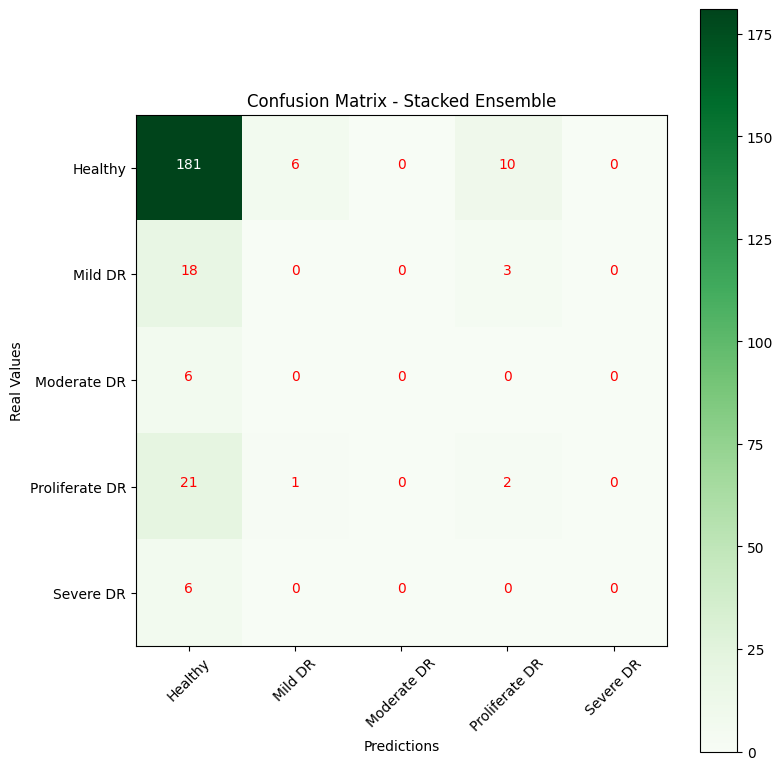

In [ ]:
X_meta_test = np.hstack([y_pred_resnet_test, y_pred_densenet_test, y_pred_efficientnet_test])
y_meta_test = Test.classes

meta_model = LogisticRegression(max_iter=1000, multi_class='ovr')
meta_model.fit(X_meta_test, y_meta_test)

y_pred_resnet_valid = model_resnet.predict(Valid)
y_pred_densenet_valid = model_densenet.predict(Valid)
y_pred_efficientnet_valid = model_efficientnet.predict(Valid)

X_meta_valid = np.hstack([y_pred_resnet_valid, y_pred_densenet_valid, y_pred_efficientnet_valid])
y_pred_classes_meta = meta_model.predict(X_meta_valid)

cm_ensemble_stacked = confusion_matrix(Valid.classes, y_pred_classes_meta)
plot_confusion_matrix(cm_ensemble_stacked, classes, title='Confusion Matrix - Stacked Ensemble')

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(Valid.classes, y_pred_classes_meta)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       197
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00         6
           3       0.13      0.08      0.10        24
           4       0.00      0.00      0.00         6

    accuracy                           0.72       254
   macro avg       0.18      0.20      0.19       254
weighted avg       0.62      0.72      0.66       254



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
